In [2]:
"""
RNN으로 이름 분류하기, https://tutorials.pytorch.kr/intermediate/char_rnn_classification_tutorial
단어 분류를 위한 문자-단위 RNN implementation & training
NLP 모델링을 위한 데이터 전처리를 위한 라이브러리(torchtext)를 사용하지 않고
학습을 위해 데이터 전처리 과정 from scratch
주어진 이름이 어떤 언어로 이루어 졌는지 예측하기 위해,
18개 언어로 된 수천 개의 이름을 학습

download data : https://download.pytorch.org/tutorial/data.zip

Good explanation post for understanding RNN and LSTM, Korean
https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr
"""
# Data preparation, from scratch
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os


def findFiles(path): return glob.glob(path)


# check the name of all files for training
print(findFiles('data/names/*.txt'))

import unicodedata
import string

# all ASCII code char & count the number of them
all_letters = string.ascii_letters + " .,;"
n_letters = len(all_letters)

print(all_letters)


# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
# unicode data normalize method : NFC, NFD, NFKD, NFKC
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != '\n'
        and c in all_letters
    )


# check Unicode to ASCII code
print(unicodeToAscii('Ślusàrski'))

# create 언어 종류 list & 언어별 학습 data
all_categories = []
category_lines = {}


# read file & split line by line >> return split file line list
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


# read training data
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

# check category type & contents(names)
print(all_categories)
print(category_lines['Italian'][:5])

'''
Name to Tensor : One-Hot vector
character - <1 * n_letters>
word - combine each char, <line_length * 1 * n_letters>
1 dim on the middle show batch 1, PyTorch assumes that everything is in batch
'''
import torch


# find the address of a character with all_letters, 'a': 0 / 'b': 1 / ...
def letterToiIndex(letter):
    return all_letters.find(letter)


# For verification, change one char to tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToiIndex(letter)] = 1
    return tensor


# one name(== one line) to One-Hot tensor array <line_length * 1 * n_letters>
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToiIndex(letter)] = 1
    return tensor


print(letterToTensor('J'))
print(lineToTensor('Jones').size())

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;
Slusarski
['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 

In [3]:
'''
Create Network
'''
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

# Example : running one step
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

# Example plus : For efficiency, make all tensors and cut them before to use
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9137, -2.9762, -2.8316, -2.9095, -2.8396, -2.8346, -2.8950, -2.9306,
         -2.8947, -2.8917, -2.8424, -2.9522, -2.9876, -2.8103, -2.9473, -2.9923,
         -2.7970, -2.8148]], grad_fn=<LogSoftmaxBackward0>)


In [4]:
'''
Prepare Network Training
'''
import random


# Change network output to likelihood category
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)  # tensor max value & address
    category_i = top_i[0].item()  # tensor to int
    return all_categories[category_i], category_i


print(categoryFromOutput(output))


# Select a random item from the list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]


# Get random training example : a name and the language that makes it up
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

('Spanish', 16)
category = Polish / line = Krol
category = Scottish / line = Mcintyre
category = Japanese / line = Sasada
category = Scottish / line = Reid
category = German / line = Kruse
category = Italian / line = Adessi
category = Scottish / line = Scott
category = Russian / line = Tubylov
category = Japanese / line = Sekozawa
category = German / line = Dohman


In [5]:
'''
Training Network

loss function : NLL (Negative Log Likelihood)
'''
criterion = nn.NLLLoss()
learning_rate = 0.005


def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)

    # backpropagation step, calculate loss gradient about all parameter
    loss.backward()

    # parameters from rnn is weight & bias for each layer
    for p in rnn.parameters():
        # update parameter, basic gradient descent - In general, use optimizer instead of basic gd
        # add -(gradient * learning_rate) to parameter
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [6]:
# Running section using downloaded data
import time
import math


n_iters = 100000
# there is 100000 of iteration (too many), so print every 5000 times
print_every = 5000
# loss record term for loss plot visualization
plot_every = 1000


# loss avg within plot_every term
current_loss = 0
# loss record for loss plot visualization
all_losses = []


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return '%dm %ds' % (m, s)


start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # print learning state
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'O' if guess == category else 'X (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s'
              % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # record loss avg
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 3s) 2.7807 Malone / German X (Irish)
10000 10% (0m 7s) 1.7556 Samios / Greek O
15000 15% (0m 11s) 1.5401 Yi / Vietnamese X (Korean)
20000 20% (0m 14s) 0.5278 Michalaras / Greek O
25000 25% (0m 18s) 0.9905 Luong / Vietnamese O
30000 30% (0m 22s) 0.9372 Krusen / Dutch O
35000 35% (0m 25s) 0.7220 Cnaimhin / Irish O
40000 40% (0m 29s) 2.6706 Lockie / Russian X (English)
45000 45% (0m 33s) 2.3210 Khoo / Korean X (Chinese)
50000 50% (0m 36s) 0.0150 Mathghamhain / Irish O
55000 55% (0m 40s) 2.0744 Van / Chinese X (Vietnamese)
60000 60% (0m 43s) 0.8625 Chi / Korean O
65000 65% (0m 47s) 1.5216 Bazzi / Polish X (Arabic)
70000 70% (0m 51s) 0.2399 Anselmi / Italian O
75000 75% (0m 54s) 0.2931 Mashita / Japanese O
80000 80% (0m 58s) 4.6314 Zaloumi / Japanese X (Greek)
85000 85% (1m 2s) 1.5163 Blecher / Czech X (German)
90000 90% (1m 5s) 0.9299 Cloutier / French O
95000 95% (1m 9s) 1.6572 Shannon / Russian X (Irish)
100000 100% (1m 13s) 2.1878 Sung / Chinese X (Korean)


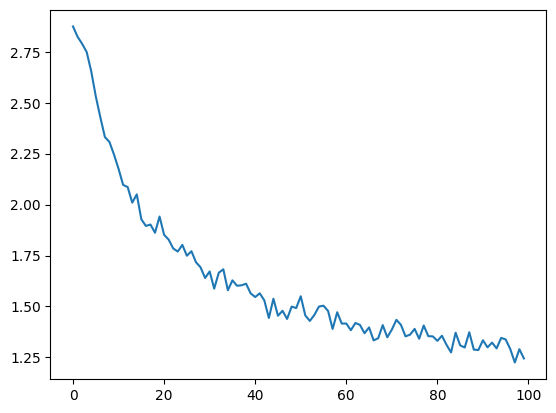

In [7]:
'''result plot (loss record) visualization'''
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

C:\Users\wpffl\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\wpffl\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator


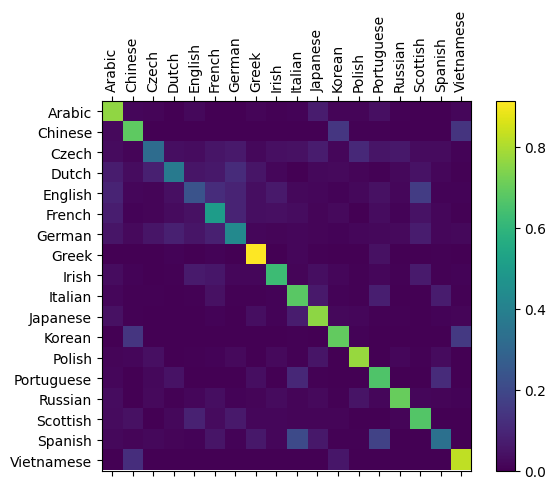

In [11]:
'''
Evaluate result (make confusion matrix)

confusion matrix : value of the probabilitythat a row is assumed to be a column
'''

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000


def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output


# record answer in confusion matrix
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# normalization
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# visulaization
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [56]:
'''Prediction experiment from user input'''

def predict(input_line, n_predictions=3):
    ranking = ['st', 'nd', 'rd', 'th']
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            rank = ranking[i] if i < len(ranking) else ranking[-1]
            print('%d%s) %s (%.2f)' % (i+1, rank, all_categories[category_index], value))
            predictions.append([value, all_categories[category_index]])


if isinstance(type(input), type(output)): del input
name = input("Please enter the name for which language prediction is desired : ")

predict(name)


> Billy
1st) Scottish (-1.01)
2nd) English (-1.29)
3rd) Irish (-1.37)
